c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:41:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:41:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Model Accuracies:
                     Accuracy
Logistic Regression  0.884793
SVM                  0.884793
Voting Ensemble      0.880184
KNN                  0.870968
Naive Bayes          0.870968
Gradient Boosting    0.870968
XGBoost              0.811060
Random Forest        0.764977
Decision Tree        0.686636


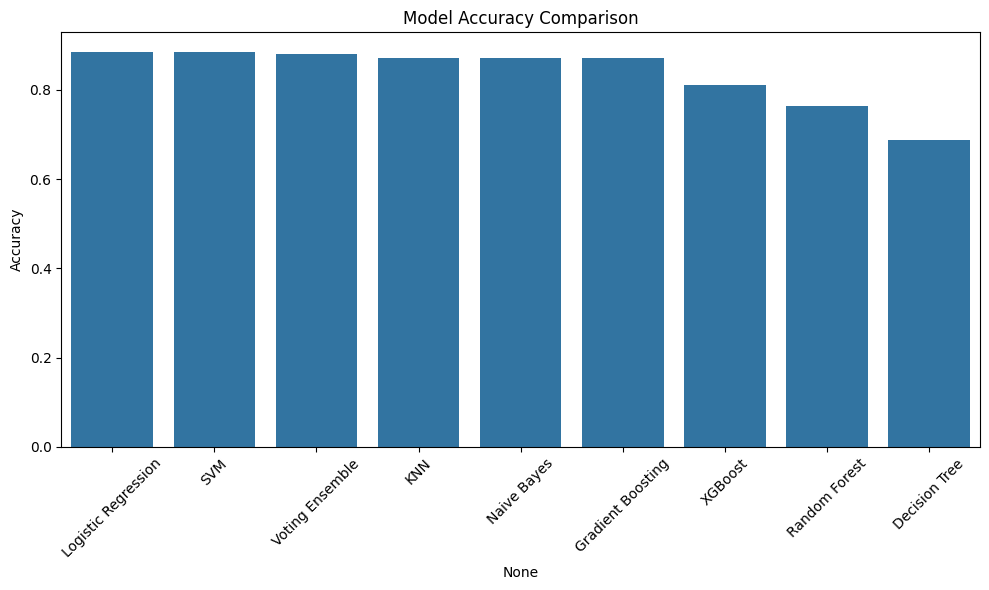


✅ Best Model Based on Accuracy: Logistic Regression (0.8848)

 Sample Predictions vs Actual:
   X-direction  Y-direction  Z-direction Actual Predicted
0     1.910331    -1.306831    -3.124911     no        no
1     0.430474    -0.387424     0.316334    yes       yes
2     0.621423    -0.387424     0.302187    yes       yes
3     0.430474     0.761836     0.330481    yes       yes
4     1.385220    -0.387424    -3.089543     no        no
5     0.239525     0.761836     0.337554    yes       yes
6    -0.142374    -1.076979     0.323407    yes       yes
7     0.239525    -0.157572     0.323407    yes       yes
8     0.621423    -1.076979    -3.165583     no        no
9    -0.142374    -0.157572     0.254441    yes       yes

 Make a Prediction from Custom Input (X, Y, Z values):

 Prediction for input [0.31, 1.02, -9.18] → NO


c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

import xgboost as xgb

# Load and preprocess data
df = pd.read_csv("ADXL345_SensorData.csv")  # Replace with your file path

# Encode target variable
le = LabelEncoder()
df['Error_found'] = le.fit_transform(df['Error_found'])  # 'no' = 0, 'yes' = 1

# Feature and target split
X = df.drop('Error_found', axis=1)
y = df['Error_found']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = { 
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

# Train and evaluate Voting Ensemble
voting_model = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft')
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)
results['Voting Ensemble'] = accuracy_score(y_test, y_pred_voting)

# Print accuracy of all models
print("\n Model Accuracies:")
accuracy_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)
print(accuracy_df)

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_df.index, y=accuracy_df['Accuracy'])
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()

# Identify best model
best_model_name = max(results, key=results.get)
best_model = voting_model if best_model_name == 'Voting Ensemble' else models[best_model_name]
print(f"\n✅ Best Model Based on Accuracy: {best_model_name} ({results[best_model_name]:.4f})")

# Final predictions
final_preds = best_model.predict(X_test)

# Show predictions vs actual
comparison_df = pd.DataFrame({
    'X-direction': X_test[:, 0],
    'Y-direction': X_test[:, 1],
    'Z-direction': X_test[:, 2],
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(final_preds)
})

print("\n Sample Predictions vs Actual:")
print(comparison_df.head(10))  # View top 10 predictions


# Predict from custom input
print("\n Make a Prediction from Custom Input (X, Y, Z values):")

try:
    x_input = float(input("Enter X-direction value: "))
    y_input = float(input("Enter Y-direction value: "))
    z_input = float(input("Enter Z-direction value: "))

    custom_input = np.array([[x_input, y_input, z_input]])

    # Pad zeros if model was trained on more features
    if custom_input.shape[1] != X.shape[1]:
        zeros = np.zeros((1, X.shape[1] - 3))
        custom_input = np.hstack((custom_input, zeros))

    # Scale the input using the same scaler
    custom_input_scaled = scaler.transform(custom_input)

    # Predict
    custom_pred = best_model.predict(custom_input_scaled)
    custom_pred_label = le.inverse_transform(custom_pred)[0]

    print(f"\n Prediction for input [{x_input}, {y_input}, {z_input}] → {custom_pred_label.upper()}")

except Exception as e:
    print(f" Invalid input or error occurred: {e}")


In [5]:
import joblib

# Save the best model
joblib.dump(best_model, 'best_model.pkl')

# Save the LabelEncoder
joblib.dump(le, 'label_encoder.pkl')

# Save the Scaler
joblib.dump(scaler, 'scaler.pkl')

print("\n✅ Best model, label encoder, and scaler saved successfully.")



✅ Best model, label encoder, and scaler saved successfully.
